In [11]:
import multiprocessing
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.environments import PendulumEnv
from src.utils import Discretizer
from src.sampler import PendulumTrajectorySampler, EpsilonGreedyPendulumTrajectorySampler
from src.trainer import QNetworkTrainer, QNetworkTester
from src.models import PARAFAC

In [41]:
gs = [1.0, 5.0, 10.0, 20.0]
m = 1
l = 1

envs = [PendulumEnv(g=g, m=m, l=l) for g in gs]

In [42]:
nS = 10
nA = 10
nT = len(gs)

discretizer = Discretizer(
    min_points_states=[-1, -5],
    max_points_states=[1, 5],
    bucket_states=[nS] * 2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [43]:
gamma = 0.9

In [44]:
def create_target(states_next, rewards, Q, tasks=None):
    if tasks is not None:
        idx_target = torch.cat((tasks.unsqueeze(1), states_next), dim=1)
    else:
        idx_target = states_next

    with torch.no_grad():
        q_target = rewards + gamma * Q(idx_target).max(dim=1).values

    return q_target

def create_idx_hat(states, actions, tasks=None):
    if tasks is not None:
        idx_hat = torch.cat((tasks.unsqueeze(1), states, actions.unsqueeze(1)), dim=1)
    else:
        idx_hat = torch.cat((states, actions.unsqueeze(1)), dim=1)
    return idx_hat

def update_model(s_idx, sp_idx, a_idx, r, Q, opt, tasks=None):
    for factor in Q.factors:
        q_target = create_target(sp_idx, r, Q, tasks)
        idx_hat = create_idx_hat(s_idx, a_idx, tasks)
        q_hat = Q(idx_hat)

        opt.zero_grad()
        loss = torch.nn.MSELoss()(q_hat, q_target)
        loss.backward()

        with torch.no_grad():
            for frozen_factor in Q.factors:
                if frozen_factor is not factor:
                    frozen_factor.grad = None

        opt.step()

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

# 0) Individual tasks

In [109]:
E = 1000
H = 100
lr = 0.01
eps = 0.1
eps_decay = 1.0
eps_min = 0.1

k = 20
n_upd = nT

env_id = 1

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [110]:
Gs = []
Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.01)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
ds = 0
for episode in range(E):
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        for _ in range(n_upd):
            update_model(s_idx, sp_idx, a_idx, r, Q, opt)

        if d:
            ds += 1
            break
  
        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)

        if h % 10 == 0:
            G = run_test_episode(Q, env_id)
            Gs.append(G)
    print(f"\rEpoch: {episode} - Return: {G}", end="")
    

Epoch: 999 - Return: -104.48754000982319

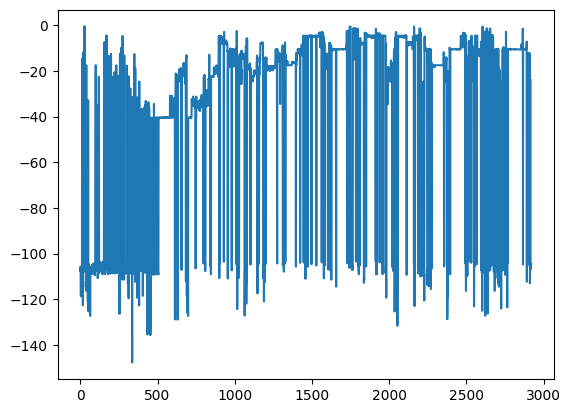

In [111]:
plt.plot(Gs)

# 1) Multi-task

In [102]:
E = 400
H = 100
lr = 0.01
eps = 0.1
eps_decay = 1.0
eps_min = 0.1
k = 20

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [103]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.01)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=torch.tensor([env_idx]))

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

            if h % 10 == 0:
                G = run_test_episode(Q, env_idx)
                Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]}", end="")

Epoch: 399 - Return: [-104.6663646558147, -104.44329212029383, -4.746377974702527, -7.603641197156199]]]]

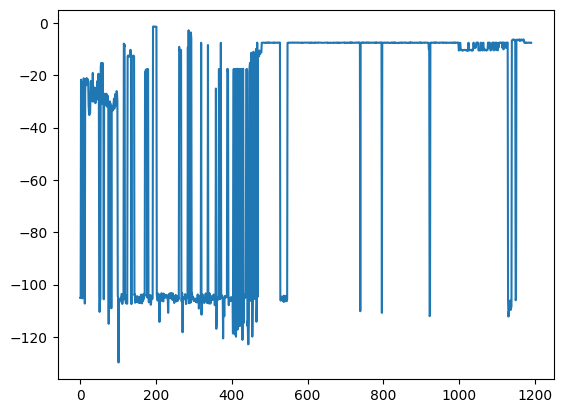

In [107]:
testid = 3
plt.plot(Gs[testid])

# 2) Single agent

In [93]:
E = 500
H = 100
lr = 0.01
eps = 0.1
eps_decay = 1.0
eps_min = 0.1
k = 20

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [94]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.01)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=None)

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

            G = run_test_episode(Q, env_idx)
            Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]}", end="")

Epoch: 373 - Return: [-10.510595937054351, -10.503154627120491, -10.500968403913285, -10.309220424913978]

KeyboardInterrupt: 

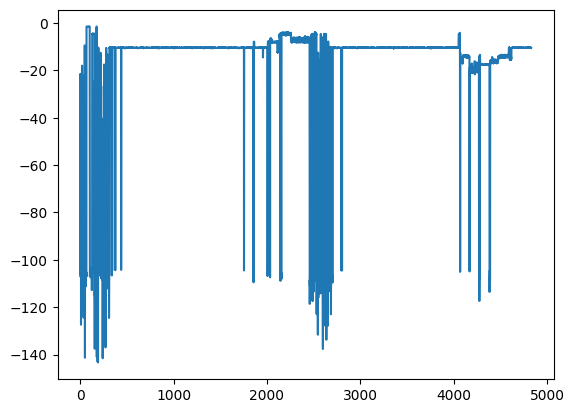

In [97]:
testid = 2
plt.plot(Gs[testid])

In [ ]:
E = 50
H = 200
lr = 0.01
eps = 0.0
eps_decay = 1.0
eps_min = 0.0
gamma = 0.99
k = 20

def run_test_episode(Q):
    Gs = []
    for id, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
        Gs.append(G)
    return Gs

# 1) Single-task all

In [115]:
E = 1
H = 100
nS = 20
nA = 20
gs = [1.0, 2.0, 5.0, 10.0]
m = 1
l = 1
nT = len(gs)

k = 100
lr = 0.001
gamma = 0.99
epochs = 1

In [37]:
n= 1

np.random.seed(n)
random.seed(n)
torch.manual_seed(n)

In [14]:
epsilon = 0.99
decay = 0.999
Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=0.1)
trainer = QNetworkTrainer(Q, lr, gamma)
res = []
for _ in range(2_000):
    sampler = EpsilonGreedyPendulumTrajectorySampler(gs, m, l, E, H, nS, nA, epsilon, Q, multi_task=False)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=128, shuffle=True)

    trainer.train(loader_mult, epochs, use_tasks=False)
    epsilon *= decay

    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=False))
res = np.array(res)

Epoch: 0 - Loss: 16.358794176015476

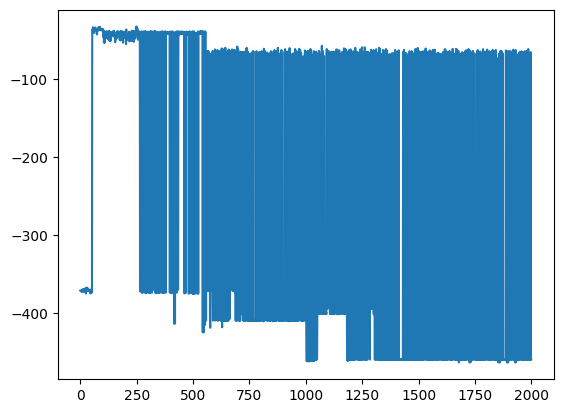

In [25]:
plt.plot(res[:, 0])

In [39]:
res = []
for _ in range(100):
    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=False))
res = np.array(res)

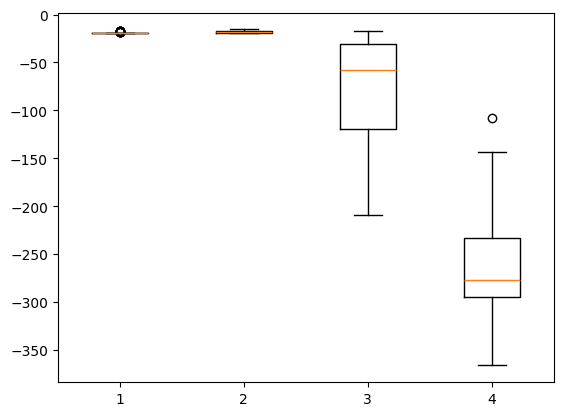

In [40]:
plt.boxplot([res[:, 0], res[:, 1], res[:, 2], res[:, 3]])
plt.show()

# 2) Multi-task

In [8]:
E = 1
H = 100
nS = 10
nA = 10
gs = [1.0, 1.0, 1.0, 1.0]
m = 1
l = 1
nT = len(gs)

k = 20
lr = 0.001
gamma = 0.99
epochs = 1

In [9]:
n= 3

np.random.seed(n)
random.seed(n)
torch.manual_seed(n)

In [12]:
epsilon = 1.0
decay = 0.9999
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=0.1, bias=0.0)
trainer = QNetworkTrainer(Q, lr, gamma)
res = []
for e in range(10_000):
    sampler = EpsilonGreedyPendulumTrajectorySampler(gs, m, l, E, H, nS, nA, epsilon, Q, multi_task=True)
    sampler.sample_data()

    dataset_mult = sampler.get_trajectories_dataset()
    loader_mult = DataLoader(dataset_mult, batch_size=1, shuffle=True)

    trainer.train(loader_mult, epochs, use_tasks=True, mono=True)
    epsilon *= decay

    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=True))

    print(f"\rEpoch: {e} - Return: {res[-1]}", end="")
res = np.array(res)

Epoch: 9999 - Return: [-339.580675496913, -279.77236269624063, -626.8362096502551, -149.6583643619903]1]]]

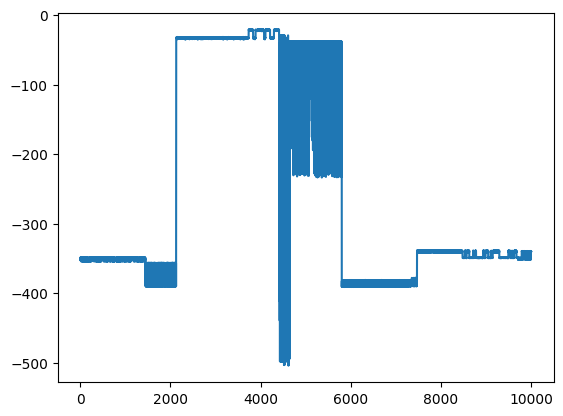

In [13]:
res = np.array(res)
plt.plot(res[:,0])

In [12]:
res = []
for _ in range(100):
    tester = QNetworkTester(Q, nS, nA, gs, m, l, H)
    res.append(tester.test(task_id=None, multi_task=True))
res = np.array(res)

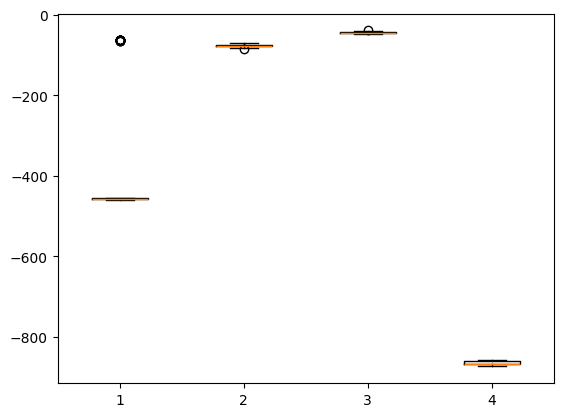

In [13]:
plt.boxplot([res[:, 0], res[:, 1], res[:, 2], res[:, 3]])
plt.show()